In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("./rice-leaf-diseases-dataset")

# print("Path to dataset files:", path)

In [16]:
print("hello")
import sys
print(sys.version)


hello
3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]


In [17]:
# ! pip install tensorflow-model-optimization
# ! pip install vitis-ai-tensorflow
# ! pip install tf-keras

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix
# import tensorflow_model_optimization as tfmot
# from tensorflow_model_optimization import sparsity
# import tf_keras as keras
import numpy as np
import time
import os
import tempfile
import zipfile
from collections import Counter
from sklearn.model_selection import train_test_split

!pip install seaborn
import seaborn as sns


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# dataset_path = '/kaggle/input/rice-leaf-diseases-dataset/rice leaf diseases dataset/'
dataset_path="./rice leaf diseases dataset"
print(dataset_path)

./rice leaf diseases dataset


In [20]:
# Set parameters
BATCH_SIZE = 128
IMG_SIZE = (224, 224)  # Standard for pre-trained models
EPOCHS = 8

In [22]:
# # Load dataset
# train_ds = image_dataset_from_directory(
#     dataset_path,  # Replace with your dataset directory
#     validation_split=0.3,
#     subset="training",
#     seed=123,
#     image_size=IMG_SIZE,
#     # label_mode="categorical",
#     batch_size=BATCH_SIZE
# )

# val_ds = image_dataset_from_directory(
#     dataset_path,  # Replace with your dataset directory
#     validation_split=0.3,
#     subset="validation",
#     seed=123,
#     # label_mode="categorical",
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE
# )


# # Get class names
# class_labels = train_ds.class_names




# # Load dataset
# train_ds = image_dataset_from_directory(
#     dataset_path,  # Replace with your dataset directory
#     validation_split=0.3,
#     subset="training",
#     seed=123,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE
# )

# val_ds = image_dataset_from_directory(
#     dataset_path,  # Replace with your dataset directory
#     validation_split=0.3,
#     subset="validation",
#     seed=123,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     shuffle=False

# )


AUTOTUNE = tf.data.AUTOTUNE

# 1. Get image paths and labels
def get_image_paths_and_labels(dataset_path):
    class_names = sorted(os.listdir(dataset_path))
    filepaths = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(idx)
    return np.array(filepaths), np.array(labels), class_names

filepaths, labels, class_names = get_image_paths_and_labels(dataset_path)

# 2. Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    filepaths, labels, 
    test_size=0.3, 
    stratify=labels, 
    random_state=42
)

# 3. Image loading and preprocessing
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize
    return img, label

# 4. Build Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(process_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(process_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [23]:
# print(class_labels)
y_true = np.concatenate([y for x, y in val_ds])
print(y_true.shape)

(5210,)


In [24]:
print(y_true[:20])

[ 5  8  9  9 10  1  2  8  6  4  7  2 10  9  1  3  9  0  9  3]


# Custom Model with Random forrest inclusion

In [10]:
# # Function to prune the model
# def prune_model(model):
#     pruning_params = {
#         'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
#     }
#     return tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# # Function to quantize the model
# def quantize_model(model):
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]
#     return converter.convert()


In [11]:
# # Function to measure model size
# def get_model_size(model, model_name):
#     model.save(f"{model_name}_temp.h5")
#     size = os.path.getsize(f"{model_name}_temp.h5") / (1024 * 1024)  # Convert bytes to MB
#     os.remove(f"{model_name}_temp.h5")
#     return size

# # Function to measure inference time
# def measure_inference_time(model, test_sample, n_runs=100):
#     start_time = time.time()
#     for _ in range(n_runs):
#         model.predict(test_sample)
#     avg_time = (time.time() - start_time) / n_runs
#     return avg_time


In [25]:
# Function to compute confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix",cm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [13]:
# # Function to create model
# def create_model(base_model):
#     # Freeze the base model layers to prevent training
#     base_model.trainable = False

#     # Add new layers on top
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(128, activation='relu')(x)
#     predictions = Dense(12, activation='softmax')(x)  # 4 classes

#     # Create final model
#     model = Model(inputs=base_model.input, outputs=predictions)
#     return model

In [14]:
# # Function to count samples in a dataset
# def count_samples_per_class(dataset, class_labels):
#     class_counts = Counter()
#     for images, labels in dataset:
#         class_counts.update(labels.numpy())  # Convert tensor to numpy array and update counter
#     return {class_labels[i]: count for i, count in class_counts.items()}

# # Count samples in training and validation datasets
# train_class_counts = count_samples_per_class(train_ds, class_labels)
# val_class_counts = count_samples_per_class(val_ds, class_labels)

# print("Training class distribution:", train_class_counts)
# print("Validation class distribution:", val_class_counts)

### models

In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [16]:
# List of pre-trained models
models = {
    # "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    # "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    # "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    # "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
}
performance_dict = {model_name: {"before": {}, "after": {}} for model_name in models}
# Dictionary to store performance metrics
performance_metrics = {model_name: {"size": {}, "inference_time": {}, "accuracy": {}} for model_name in models}
# Dictionary to store history for plotting
history_dict = {}

## TEST

C:\Users\MSC04\AppData\Local\Temp\ipykernel_3056\1010827096.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


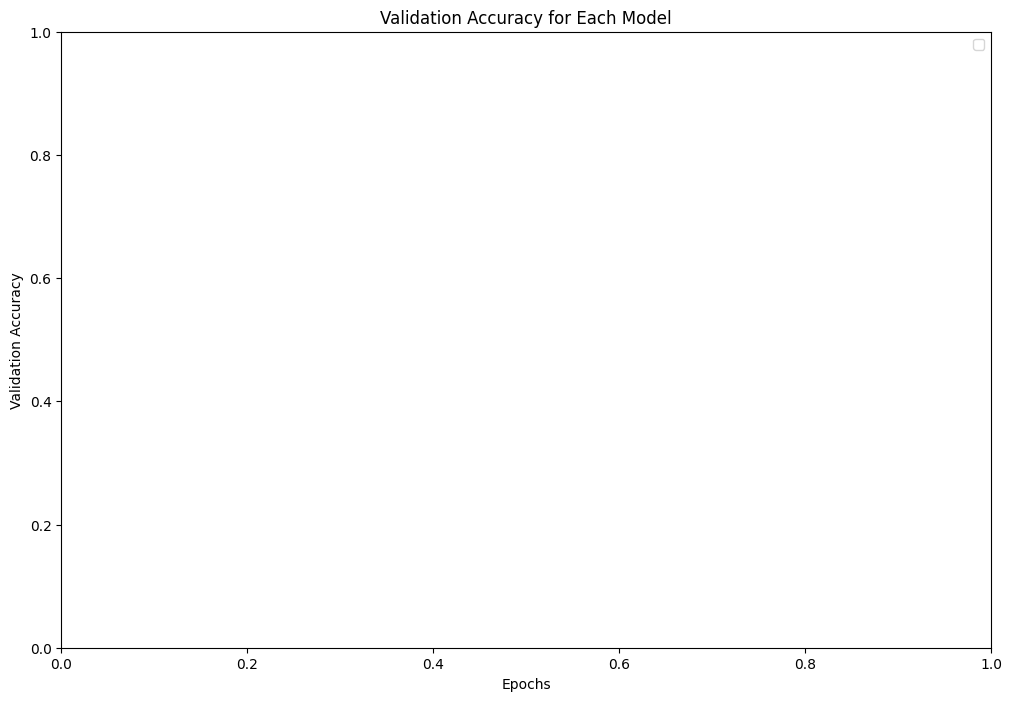

In [17]:
for name, base_model in models.items():
    print(f"Optimizing model: {name}")
    
    # Load and create the model
    model = create_model(base_model)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])
    history_dict[name] = history.history
    
    # Save the unoptimized model's size, inference time, and accuracy
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
    model.save(temp_file.name)
    model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
    start_time = time.time()
    _, accuracy = model.evaluate(val_ds)
    inference_time = time.time() - start_time
    performance_metrics[name]['size']['original'] = model_size
    performance_metrics[name]['inference_time']['original'] = inference_time
    performance_metrics[name]['accuracy']['original'] = accuracy

    
    # Apply pruning
    # pruned_model = prune_model(model)
    # pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # pruned_history = pruned_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])
    # pruned_model_stripped = tfmot.sparsity.keras.strip_pruning(pruned_model)
    
    # Save the pruned model's size, inference time, and accuracy
    # temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
    # pruned_model_stripped.save(temp_file.name)
    # pruned_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)
    # start_time = time.time()
    # _, pruned_accuracy = pruned_model_stripped.evaluate(val_ds)
    # pruned_inference_time = time.time() - start_time
    # performance_metrics[name]['size']['pruned'] = pruned_model_size
    # performance_metrics[name]['inference_time']['pruned'] = pruned_inference_time
    # performance_metrics[name]['accuracy']['pruned'] = pruned_accuracy

    # Collect true labels
    y_true = np.concatenate([y for x, y in val_ds])

    # Get predictions
    y_pred_prob = model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)


    # Code to get confusion matrices
    # Plot confusion matrix
    # plot_confusion_matrix(y_true, y_pred, name)
    

# Plot accuracy for each model
plt.figure(figsize=(12, 8))
for model_name, history in history_dict.items():
    plt.plot(history['val_accuracy'], label=f"{model_name} (Original)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Each Model")
plt.legend()
plt.show()


C:\Users\MSC04\AppData\Local\Temp\ipykernel_3056\1390344113.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


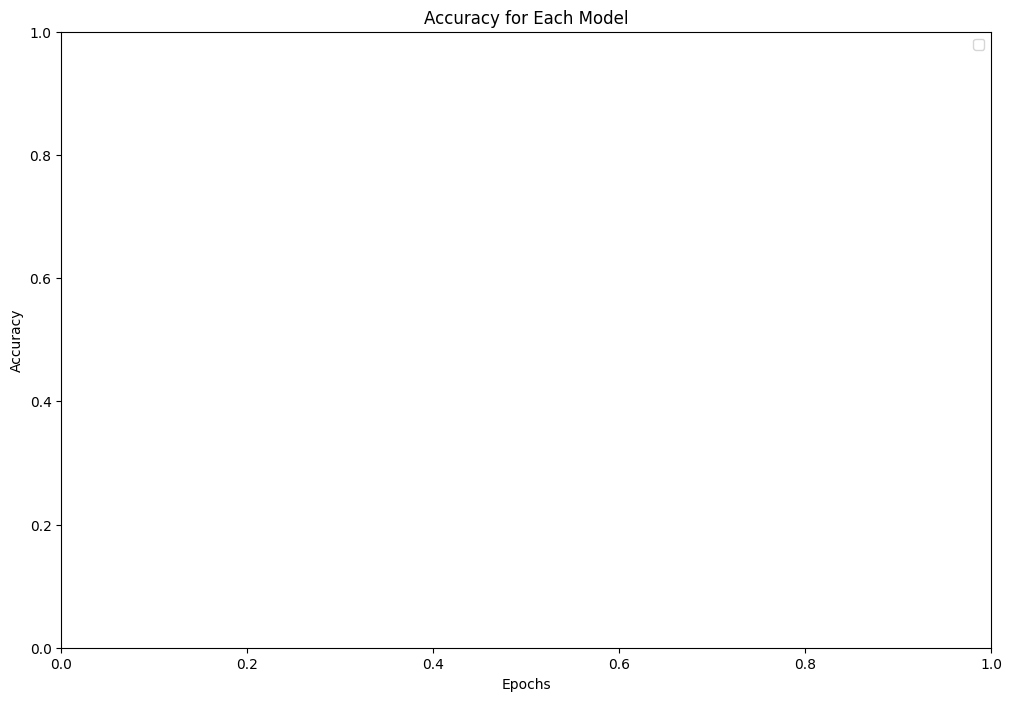

In [18]:
# print(history_dict.items())

plt.figure(figsize=(12, 8))
for model_name, history in history_dict.items():
    plt.plot(history['accuracy'], label=f"{model_name} (Original)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for Each Model")
plt.legend()
plt.show()

In [19]:
performance_comparison = {}

In [20]:
labels = ["Size (MB)", "Latency (s)"]
for model_name, metrics in performance_comparison.items():
    before = [metrics["Original Size (MB)"], metrics["Original Latency (s)"]]
    after = [metrics["Optimized Size (MB)"], metrics["Optimized Latency (s)"]]
    
    x = range(len(labels))
    plt.figure(figsize=(8, 6))
    plt.bar(x, before, width=0.4, label="Before Optimization", align='center')
    plt.bar([p + 0.4 for p in x], after, width=0.4, label="After Optimization", align='center')
    plt.xticks([p + 0.2 for p in x], labels)
    plt.title(f"Performance Comparison for {model_name}")
    plt.ylabel("Metrics")
    plt.legend()
    plt.show()


In [21]:



# Train each model and save the accuracy history
# performance_metrics = {model_name: {"size": {}, "inference_time": {}} for model_name in models}

# for name, base_model in models.items():
#     print(f"Optimizing model: {name}")
    
#     # Load and create the model
#     model = create_model(base_model)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#     # Train the model
#     early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#     model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])

#     # Save the unoptimized model's size and inference time
#     temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
#     model.save(temp_file.name)
#     model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
#     start_time = time.time()
#     _ = model.predict(val_ds)
#     inference_time = time.time() - start_time
#     performance_metrics[name]['size']['original'] = model_size
#     performance_metrics[name]['inference_time']['original'] = inference_time
    
    # Apply pruning
    # Apply pruning correctly before training
#     pruned_model = prune_model(model)
#     pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#     # Train the pruned model
#     early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#     pruned_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])
#     pruned_model_stripped = tfmot.sparsity.keras.strip_pruning(pruned_model)


    
#     temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
#     pruned_model_stripped.save(temp_file.name)
#     pruned_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)
#     start_time = time.time()
#     _ = pruned_model_stripped.predict(val_ds)
#     pruned_inference_time = time.time() - start_time
#     performance_metrics[name]['size']['pruned'] = pruned_model_size
#     performance_metrics[name]['inference_time']['pruned'] = pruned_inference_time
    
#     # Apply quantization
#     quantized_model = quantize_model(pruned_model_stripped)
#     quantized_file = tempfile.NamedTemporaryFile(delete=False, suffix=".tflite")
#     with open(quantized_file.name, 'wb') as f:
#         f.write(quantized_model)
#     quantized_model_size = os.path.getsize(quantized_file.name) / (1024 * 1024)
    
#     interpreter = tf.lite.Interpreter(model_path=quantized_file.name)
#     interpreter.allocate_tensors()
#     input_details = interpreter.get_input_details()
#     output_details = interpreter.get_output_details()
    
#     start_time = time.time()
#     for batch in val_ds.take(1):
#         inputs = batch[0].numpy()
#         interpreter.set_tensor(input_details[0]['index'], inputs)
#         interpreter.invoke()
#         outputs = interpreter.get_tensor(output_details[0]['index'])
#     quantized_inference_time = time.time() - start_time

#     performance_metrics[name]['size']['quantized'] = quantized_model_size
#     performance_metrics[name]['inference_time']['quantized'] = quantized_inference_time

# # Print results
# print("\nPerformance Metrics:")
# for model_name, metrics in performance_metrics.items():
#     print(f"\nModel: {model_name}")
#     print("Size (MB):", metrics['size'])
#     print("Inference Time (s):", metrics['inference_time'])


In [22]:
# for i,j in val_ds.take(0):
#     print(i)
#     print(j)


## LIME IMPLEMENTATION

In [23]:
# import numpy as np
# from lime import lime_image
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt

# # Load a single image for explanation
# image_batch, label_batch = next(iter(val_ds))  # Fetch a batch of images from the validation dataset
# img = image_batch[0].numpy().astype('double')  # Pick the first image and convert it to numpy array
# true_label = label_batch[0].numpy()


# # LIME explainer for image
# explainer = lime_image.LimeImageExplainer()

# # Prediction function: Preprocess the image and use the model to predict
# def predict_fn(images):
#     images = np.array(images)
#     preds = model.predict(images)
#     return preds

# # Explain the prediction for the chosen image
# explanation = explainer.explain_instance(
#     img, 
#     predict_fn, 
#     top_labels=4,  # Number of top labels to consider
#     hide_color=0, 
#     num_samples=1000  # Number of perturbed samples to generate
# )




In [24]:
# # Visualize explanation
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Positive regions for the top predicted label
# temp, mask = explanation.get_image_and_mask(
#     label=explanation.top_labels[0],  # Top predicted class
#     positive_only=True,
#     num_features=4, 
#     hide_rest=True
# )

# # Display original image
# axes[0].imshow(img / 255.0)  # Normalize image
# axes[0].set_title("Original Image")
# axes[0].axis('off')

# # Display explanation with LIME highlighting regions
# axes[1].imshow(mark_boundaries(temp / 255.0, mask))  # Highlighted regions
# axes[1].set_title("LIME Explanation")
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()

## Grad Cam Implementation

In [25]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2

# # Function to compute Grad-CAM
# def compute_gradcam(model, img_array, layer_name, class_index):
#     # Create a model that maps the input image to the activations of the specified layer and predictions
#     # grad_model = tf.keras.models.Model(
#     #     inputs=[model.inputs],
#     #     outputs=[model.get_layer(layer_name).output, model.output]
#     # )

#     grad_model = tf.keras.models.Model(
#     inputs=model.input,  # Use model.input or model.inputs directly
#     outputs=[model.get_layer(layer_name).output, model.output]
#     )

#     # Compute gradients
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(tf.expand_dims(img_array, axis=0))
#         loss = predictions[:, class_index]  # Get the score for the predicted class
    
#     # Gradients of the loss w.r.t the convolutional layer output
#     grads = tape.gradient(loss, conv_outputs)
#     output = conv_outputs[0]
#     grads = grads[0]

#     # Compute the weights for Grad-CAM
#     weights = tf.reduce_mean(grads, axis=(0, 1))  # Global average pooling of gradients
#     cam = np.dot(output, weights)  # Weighted sum of feature maps

#     # Apply ReLU to the Grad-CAM
#     cam = np.maximum(cam, 0)

#     # Normalize the Grad-CAM to [0, 1]
#     cam = cam / np.max(cam)
#     return cam

# # Choose a convolutional layer to explain (last conv layer)
# last_conv_layer = "conv5_block3_out"  # Replace with your model's last convolutional layer

# # Load a single image for Grad-CAM
# image_batch, label_batch = next(iter(val_ds))  # Fetch a batch of images
# img = image_batch[0].numpy()  # Select the first image
# img_resized = img / 255.0  # Normalize for visualization
# true_label = label_batch[0].numpy()

# # Get the predicted class
# preds = model.predict(np.expand_dims(img, axis=0))
# predicted_class = np.argmax(preds[0])

# # Compute Grad-CAM
# gradcam = compute_gradcam(model, img, last_conv_layer, predicted_class)

# # Resize Grad-CAM to match the input image
# gradcam_resized = cv2.resize(gradcam, (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * gradcam_resized)

# # Overlay Grad-CAM heatmap on the original image
# jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# overlay = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, jet, 0.4, 0)

# # Visualize Grad-CAM
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Original Image
# axes[0].imshow(img_resized)
# axes[0].set_title("Original Image")
# axes[0].axis('off')

# # Grad-CAM Heatmap
# axes[1].imshow(overlay[:, :, ::-1])  # Convert BGR back to RGB
# axes[1].set_title("Grad-CAM Heatmap")
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()


In [26]:
# plt.figure(figsize=(24, 8))  # Adjust the figure size to accommodate two plots side by side

# # First subplot: Training Accuracy
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# for name, history in history_dict.items():
#     plt.plot(history.history['accuracy'], label=name)
# plt.title('Model Training Accuracy Comparison')
# plt.ylabel('Training Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# # Second subplot: Validation Accuracy
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# for name, history in history_dict.items():
#     plt.plot(history.history['val_accuracy'], label=name)
# plt.title('Model Validation Accuracy Comparison')
# plt.ylabel('Validation Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# plt.show()

In [27]:
# print((history.__dict__))

In [28]:
# plt.figure(figsize=(30, 8))  # Adjust the figure size to accommodate two plots side by side

# # First subplot: Training Accuracy
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# for name, history in history_dict.items():
#     plt.plot(history.history['loss'], label=name)
# plt.title('Model Training loss Comparison')
# plt.ylabel('Training loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# # Second subplot: Validation Accuracy
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# for name, history in history_dict.items():
#     plt.plot(history.history['val_loss'], label=name)
# plt.title('Model Validation Loss Comparison')
# plt.ylabel('Validation Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# plt.show()

In [29]:
# selected_model = models['ResNet50']  # Example: you can choose another model
# for images, labels in val_ds.take(1):  # Take a single batch from validation data
#     image = images[0].numpy()  # Get the first image in the batch
#     label = labels[0].numpy()  # Get the corresponding label

In [30]:
# def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
#     # Define the model for Grad-CAM
#     grad_model = tf.keras.models.Model(
#         inputs=model.input,
#         outputs=[model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     # Record the gradients of the predicted class
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         top_class_idx = tf.argmax(predictions[0])
#         top_class_output = predictions[:, top_class_idx]

#     # Compute the gradients
#     grads = tape.gradient(top_class_output, conv_outputs)

#     # Pool the gradients across the spatial dimensions
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # Expand dimensions of pooled_grads to match conv_outputs
#     pooled_grads = tf.expand_dims(tf.expand_dims(pooled_grads, 0), 0)

#     # Element-wise multiplication
#     conv_outputs = conv_outputs[0]
#     conv_outputs = conv_outputs * pooled_grads

#     # Compute the heatmap
#     heatmap = tf.reduce_mean(conv_outputs, axis=-1)
#     heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-7)  # Normalize the heatmap
#     return heatmap.numpy()




# # Display Grad-CAM
# def display_gradcam(model, img_path, last_conv_layer_name):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array = preprocess_input(img_array)

#     heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)

#     # Resize heatmap to match the original image
#     heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
#     heatmap = np.uint8(255 * heatmap)

#     # Apply colormap to heatmap
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#     # Superimpose the heatmap on the original image
#     superimposed_img = heatmap * 0.4 + img_array[0]
#     superimposed_img = np.uint8(superimposed_img)

#     # Display the image with Grad-CAM
#     plt.figure(figsize=(10, 10))
#     plt.subplot(1, 2, 1)
#     plt.title("Original Image")
#     plt.imshow(img / 255.0)
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.title("Grad-CAM")
#     plt.imshow(superimposed_img)
#     plt.axis('off')
#     plt.show()
    
# sample_image_path = "/kaggle/input/rice-leaf-diseases-dataset/rice leaf diseases dataset/Brownspot/Brownspot (1).jpg"

# selected_model = models["ResNet50"]
# last_conv_layer_name = "conv5_block3_out"  # Ch
# display_gradcam(selected_model, sample_image_path, last_conv_layer_name)


In [31]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [32]:
# def measure_inference_time(model, dataset):
#     start_time = time.time()
#     for images, _ in dataset.take(10):
#         _ = model.predict(images)
#     return (time.time() - start_time) / 10

# original_inference_time = measure_inference_time(model, val_ds)

## Transformer Models

In [33]:
# ! pip install torch torchvision transformers datasets timm


In [26]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from transformers import DeiTForImageClassification, BeitForImageClassification, AutoImageProcessor
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
import torch.nn.functional as F

In [27]:
# For transformer models
def get_all_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds


In [28]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset path
dataset_path = "./rice leaf diseases dataset"

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load full dataset
full_dataset = ImageFolder(root=dataset_path, transform=transform)
num_classes = len(full_dataset.classes)
print("NUM OF CLASS:", num_classes)

# Extract targets (class indices) for stratification
targets = [sample[1] for sample in full_dataset.samples]

# Create stratified split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))

# Create subset datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

# Data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM OF CLASS: 11


# Grad Cam for Transformer Model

In [37]:
# ! pip install vit-grad-cam

In [38]:
# from vit_grad_cam import VITGradCAM, show_cam_on_image

# def generate_gradcam(model, image_tensor, model_type="deit"):
#     model.eval()
#     if model_type == "deit":
#         target_layer = model.deit.encoder.layer[-1].layernorm_before
#     elif model_type == "beit":
#         target_layer = model.beit.encoder.layer[-1].layernorm_before
#     elif model_type == "swin":
#         target_layer = model.swin.encoder.layers[-1].blocks[-1].layernorm_before
#     else:
#         raise ValueError("Unsupported model_type.")

#     cam = VITGradCAM(model=model, target_layer=target_layer, use_cuda=torch.cuda.is_available())
#     grayscale_cam = cam(input_tensor=image_tensor)[0]

#     # For visualization
#     image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
#     image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
#     cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

#     plt.imshow(cam_image)
#     plt.axis("off")
#     plt.title(f"Grad-CAM for {model_type.upper()}")
#     plt.show()


In [29]:
# import torch
# import time
# import os
# from torch import nn, optim

# from transformers import DeiTForImageClassification, BeitForImageClassification, SwinForImageClassification

# # Function to get model size
# def get_model_size(model, filename="temp_model.pth"):
#     torch.save(model.state_dict(), filename)
#     size_mb = os.path.getsize(filename) / (1024 * 1024)  # Convert to MB
#     os.remove(filename)  # Clean up file
#     return size_mb

# # Function to measure inference time
# def measure_inference_time(model, sample_input, num_runs=100):
#     model.eval()
#     with torch.no_grad():
#         start_time = time.time()
#         for _ in range(num_runs):
#             _ = model(sample_input).logits
#         end_time = time.time()
#     return (end_time - start_time) / num_runs  # Average time per inference

# # Apply quantization to shrink the model
# def quantize_model(model):
#     model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
#     return model

    


# # Train and validate models
# # Function to calculate accuracy
# def calculate_accuracy(model, data_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images).logits
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
#     return correct / total


# # Train and validate models
# def train_and_validate_model(model, optimizer, num_epochs=20):
#     for epoch in range(num_epochs):
#         model.train()
#         correct_train = 0
#         total_train = 0
#         running_loss = 0.0
        
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images).logits
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             # Compute training accuracy
#             _, predicted = torch.max(outputs, 1)
#             correct_train += (predicted == labels).sum().item()
#             total_train += labels.size(0)
#             running_loss += loss.item()

#         train_accuracy = correct_train / total_train
#         val_accuracy = calculate_accuracy(model, val_loader)
#         avg_loss = running_loss / len(train_loader)
        
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, "
#               f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

#     # Output model size after training
#     size_before = get_model_size(model)
#     print(f"Model size before quantization: {size_before:.2f} MB")
    
#     # # Quantize model
#     # model = quantize_model(model)
#     # size_after = get_model_size(model)
#     # print(f"Model size after quantization: {size_after:.2f} MB")
    
#     # # Measure inference time
#     # sample_input = torch.randn(1, 3, 224, 224).to(device)
#     # avg_inference_time = measure_inference_time(model, sample_input)
#     # print(f"Average inference time: {avg_inference_time:.6f} seconds")

#     # # Evaluate accuracy after quantization
#     # quantized_val_accuracy = calculate_accuracy(model, val_loader)
#     # print(f"Validation Accuracy after quantization: {quantized_val_accuracy:.4f}")
    
#     return model


# # Load and process models
# deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels=num_classes).to(device)
# beit_model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224", num_labels=num_classes, ignore_mismatched_sizes=True).to(device)
# swin_model = SwinForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224", num_labels=num_classes,  ignore_mismatched_sizes=True).to(device)
# # Load lightweight Swin model (Swin-Tiny)
# swin_tiny_model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224",num_labels=num_classes,ignore_mismatched_sizes=True).to(device)


# criterion = nn.CrossEntropyLoss()

# learning_rate = 2e-5

# #Tested Learning rate = 0.02, 0.0008

# optimizer_deit = optim.AdamW(deit_model.parameters(), lr=learning_rate)
# optimizer_beit = optim.AdamW(beit_model.parameters(), lr=learning_rate)
# optimizer_swin = optim.AdamW(swin_model.parameters(), lr=learning_rate)
# optimizer_swin_tiny = optim.AdamW(swin_tiny_model.parameters(), lr=learning_rate)


# #Num of EPOHCS -
epochs = 10


# print("Training and validating Lightweight Swin Transformer (Swin-Tiny)...")
# swin_tiny_model = train_and_validate_model(swin_tiny_model, optimizer_swin_tiny, epochs)

# print("Training and validating DEiT...")
# deit_model = train_and_validate_model(deit_model, optimizer_deit,epochs)

# print("Training and validating BEiT...")
# beit_model = train_and_validate_model(beit_model, optimizer_beit,epochs)

# print("Training and validating Swin Transformer V2...")
# swin_model = train_and_validate_model(swin_model, optimizer_swin,epochs)

import torch
import time
import os
from torch import nn, optim
from transformers import SwinModel, DeiTConfig
from transformers import DeiTForImageClassification, BeitForImageClassification

# Your dataset loaders should already be defined
# Assume train_loader, val_loader, num_classes, device are defined

# Function to get model size
def get_model_size(model, filename="temp_model.pth"):
    torch.save(model.state_dict(), filename)
    size_mb = os.path.getsize(filename) / (1024 * 1024)
    os.remove(filename)
    return size_mb

# Function to measure inference time
def measure_inference_time(model, sample_input, num_runs=100):
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        for _ in range(num_runs):
            _ = model(sample_input).logits
        end_time = time.time()
    return (end_time - start_time) / num_runs

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Training loop
def train_and_validate_model(model, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            running_loss += loss.item()

        train_accuracy = correct_train / total_train
        val_accuracy = calculate_accuracy(model, val_loader)
        avg_loss = running_loss / len(train_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, "
              f"Training Acc: {train_accuracy:.4f}, Validation Acc: {val_accuracy:.4f}")

    size_before = get_model_size(model)
    print(f"Model size before quantization: {size_before:.2f} MB")
    return model

# 🔧 Custom Hybrid Model: Swin-Tiny + DeiT-style Head
class SwinTinyWithDeiTHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224", add_pooling_layer=False)
        self.hidden_size = self.backbone.config.hidden_size

        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.hidden_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.norm = nn.LayerNorm(self.hidden_size)
        self.head = nn.Linear(self.hidden_size, num_classes)

    def forward(self, x):
        features = self.backbone(x).last_hidden_state  # [B, num_patches, hidden_size]
        B = features.size(0)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, hidden_size]
        x = torch.cat((cls_tokens, features), dim=1)   # [B, 1 + num_patches, hidden_size]

        x = self.transformer(x)
        x = self.norm(x[:, 0])  # CLS token
        logits = self.head(x)
        return torch.nn.functional.softmax(logits, dim=-1).unsqueeze(1)  # wrap into .logits for compatibility

    @property
    def logits(self):
        return self.head

# # 🔥 Instantiate models
deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels=num_classes).to(device)
beit_model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224", num_labels=num_classes, ignore_mismatched_sizes=True).to(device)
swin_tiny_deit_head = SwinTinyWithDeiTHead(num_classes).to(device)

# ⚙️ Define loss and optimizers
criterion = nn.CrossEntropyLoss()
learning_rate = 2e-5

optimizer_deit = optim.AdamW(deit_model.parameters(), lr=learning_rate)
optimizer_beit = optim.AdamW(beit_model.parameters(), lr=learning_rate)
optimizer_swin_deit = optim.AdamW(swin_tiny_deit_head.parameters(), lr=learning_rate)

# 🔁 Train models
print("Training Swin-Tiny + DeiT head...")
swin_tiny_deit_head = train_and_validate_model(swin_tiny_deit_head, optimizer_swin_deit, epochs)

# print("Training DEiT...")
# deit_model = train_and_validate_model(deit_model, optimizer_deit, epochs)

# print("Training BEiT...")
# beit_model = train_and_validate_model(beit_model, optimizer_beit, epochs)



Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Swin-Tiny + DeiT head...


AttributeError: 'Tensor' object has no attribute 'logits'

In [30]:
import torch
import time
import os
from torch import nn, optim
from transformers import SwinModel, DeiTConfig
from transformers import DeiTForImageClassification, BeitForImageClassification

# Function to get model size
def get_model_size(model, filename="temp_model.pth"):
    torch.save(model.state_dict(), filename)
    size_mb = os.path.getsize(filename) / (1024 * 1024)
    os.remove(filename)
    return size_mb

# Function to measure inference time
def measure_inference_time(model, sample_input, num_runs=100):
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        for _ in range(num_runs):
            _ = model(sample_input).logits
        end_time = time.time()
    return (end_time - start_time) / num_runs

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Training loop
def train_and_validate_model(model, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            running_loss += loss.item()

        train_accuracy = correct_train / total_train
        val_accuracy = calculate_accuracy(model, val_loader)
        avg_loss = running_loss / len(train_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, "
              f"Training Acc: {train_accuracy:.4f}, Validation Acc: {val_accuracy:.4f}")

    size_before = get_model_size(model)
    print(f"Model size before quantization: {size_before:.2f} MB")
    return model

# 🔧 Custom Output Class to mimic Hugging Face output format
class ModelOutput:
    def __init__(self, logits):
        self.logits = logits

# 🔧 Custom Hybrid Model: Swin-Tiny + DeiT-style Head (CORRECTED)
class SwinTinyWithDeiTHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224", add_pooling_layer=False)
        self.hidden_size = self.backbone.config.hidden_size

        # DeiT-style components
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.hidden_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.norm = nn.LayerNorm(self.hidden_size)
        self.head = nn.Linear(self.hidden_size, num_classes)

    def forward(self, x):
        # Get Swin backbone features
        features = self.backbone(x).last_hidden_state  # [B, num_patches, hidden_size]
        B = features.size(0)

        # Add CLS token (DeiT-style)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, hidden_size]
        x = torch.cat((cls_tokens, features), dim=1)   # [B, 1 + num_patches, hidden_size]

        # Apply transformer layer (DeiT-style processing)
        x = self.transformer(x)
        x = self.norm(x[:, 0])  # Use CLS token for classification
        logits = self.head(x)
        
        # Return in Hugging Face format
        return ModelOutput(logits)

# Alternative approach: Create a more complete Hugging Face-compatible output
class HuggingFaceCompatibleOutput:
    def __init__(self, logits, hidden_states=None, attentions=None):
        self.logits = logits
        self.hidden_states = hidden_states
        self.attentions = attentions

# Even better version with full compatibility
class SwinTinyWithDeiTHeadV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224", add_pooling_layer=False)
        self.hidden_size = self.backbone.config.hidden_size

        # DeiT-style components
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.hidden_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.norm = nn.LayerNorm(self.hidden_size)
        self.head = nn.Linear(self.hidden_size, num_classes)

    def forward(self, pixel_values=None, **kwargs):
        # Handle both direct tensor input and keyword arguments
        if pixel_values is None:
            pixel_values = kwargs.get('input_ids', kwargs.get('inputs', None))
        
        # Get Swin backbone features
        features = self.backbone(pixel_values).last_hidden_state  # [B, num_patches, hidden_size]
        B = features.size(0)

        # Add CLS token (DeiT-style)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, hidden_size]
        x = torch.cat((cls_tokens, features), dim=1)   # [B, 1 + num_patches, hidden_size]

        # Apply transformer layer (DeiT-style processing)
        x = self.transformer(x)
        x = self.norm(x[:, 0])  # Use CLS token for classification
        logits = self.head(x)
        
        # Return in Hugging Face format
        return HuggingFaceCompatibleOutput(logits)

# 🔥 Instantiate models
deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels=num_classes).to(device)
beit_model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224", num_labels=num_classes, ignore_mismatched_sizes=True).to(device)

# Use the corrected version
swin_tiny_deit_head = SwinTinyWithDeiTHead(num_classes).to(device)
# Or use the V2 version for better compatibility
# swin_tiny_deit_head = SwinTinyWithDeiTHeadV2(num_classes).to(device)

# ⚙️ Define loss and optimizers
criterion = nn.CrossEntropyLoss()
learning_rate = 2e-5

optimizer_deit = optim.AdamW(deit_model.parameters(), lr=learning_rate)
optimizer_beit = optim.AdamW(beit_model.parameters(), lr=learning_rate)
optimizer_swin_deit = optim.AdamW(swin_tiny_deit_head.parameters(), lr=learning_rate)

epochs = 10

# 🔁 Train models
print("Training Swin-Tiny + DeiT head...")
swin_tiny_deit_head = train_and_validate_model(swin_tiny_deit_head, optimizer_swin_deit, epochs)

# print("Training DEiT...")
# deit_model = train_and_validate_model(deit_model, optimizer_deit, epochs)

# print("Training BEiT...")
# beit_model = train_and_validate_model(beit_model, optimizer_beit, epochs)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Swin-Tiny + DeiT head...
Epoch 1/10, Loss: 0.3154, Training Acc: 0.9064, Validation Acc: 0.9760
Epoch 2/10, Loss: 0.0385, Training Acc: 0.9896, Validation Acc: 0.9871
Epoch 3/10, Loss: 0.0169, Training Acc: 0.9960, Validation Acc: 0.9891
Epoch 4/10, Loss: 0.0112, Training Acc: 0.9965, Validation Acc: 0.9904
Epoch 5/10, Loss: 0.0135, Training Acc: 0.9960, Validation Acc: 0.9935
Epoch 6/10, Loss: 0.0066, Training Acc: 0.9981, Validation Acc: 0.9931
Epoch 7/10, Loss: 0.0135, Training Acc: 0.9960, Validation Acc: 0.9875
Epoch 8/10, Loss: 0.0039, Training Acc: 0.9988, Validation Acc: 0.9906
Epoch 9/10, Loss: 0.0038, Training Acc: 0.9988, Validation Acc: 0.9864
Epoch 10/10, Loss: 0.0011, Training Acc: 0.9998, Validation Acc: 0.9944
Model size before quantization: 126.37 MB


## Explainilibity CODE

In [ ]:
# print(deit_model)

image_paths = {
    "Brown Spot":"./rice leaf diseases dataset/Brownspot/Brownspot (2).jpg",
    "Tungro":"./rice leaf diseases dataset/tungro/tungro12.jpg",
    "Leaf Smut":"./rice leaf diseases dataset/Leafsmut/Leafsmut (43).JPG",
    "Leaf Blast":"./rice leaf diseases dataset/leaf_blast/leaf_blast5.jpg"
}

In [ ]:
! pip install timm


In [ ]:
from PIL import Image
import cv2


def get_deit_attention_rollout(model, image_path, transform, device,model_name="deit"):
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Forward pass with attention outputs
    with torch.no_grad():
        outputs = model(input_tensor, output_attentions=True)
        attentions = outputs.attentions  # Tuple of (layer, B, Heads, Tokens, Tokens)

    # Perform attention rollout
    num_tokens = attentions[0].size(-1)  # Should be 198 for distilled DeiT
    result = torch.eye(num_tokens).to(device)
    for attn in attentions:
        attn_heads_fused = attn[0].mean(dim=0)  # (Tokens, Tokens)
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
        result = attn_heads_fused @ result

    # Get attention from CLS token
    class_attn = result[0]  # Shape: (198,)

    # Skip both CLS and DISTILL tokens
    if model_name=="deit":
        patch_attn = class_attn[2:]  # Shape: (196,)

        

    # For beit do this
    elif model_name=="beit":
        patch_attn = class_attn[1:]
        
    # patch_attn = class_attn[1:]  # For BEiT (skip CLS only)


    if patch_attn.shape[0] != 196:
        raise ValueError(f"Expected 196 patch tokens, got {patch_attn.shape[0]}")

    # Reshape to 14x14
    mask = patch_attn.reshape(14, 14).cpu().numpy()

    # Normalize and convert to heatmap
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    heatmap = cv2.resize(mask, image.size)
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend with original image
    image_np = np.array(image)
    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # Show
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image_np)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Attention Rollout (DeiT)")
    plt.imshow(overlay)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:

for name,image in image_paths.items():
    print(name)
    get_deit_attention_rollout(deit_model, image, transform, device)

    


In [ ]:
for name,image in image_paths.items():
    print(name)
    get_deit_attention_rollout(beit_model, image, transform, device,model_name="beit")


### GradCame for Swin Transformer

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import cv2

def swin_gradcam(model, image_path, transform, device):
    model.eval()
    model.to(device)

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Hooks
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        if isinstance(output, tuple):
            activations.append(output[0])
        else:
            activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Select a deep Swin block layer
    target_block = model.swin.encoder.layers[-1].blocks[-1]
    forward_handle = target_block.register_forward_hook(forward_hook)
    backward_handle = target_block.register_full_backward_hook(backward_hook)

    # Forward + backward
    output = model(input_tensor)
    class_idx = output.logits.argmax(dim=1).item()
    model.zero_grad()
    output.logits[0, class_idx].backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Extract gradients and activations
    grads_val = gradients[0]  # (1, N, C)
    acts_val = activations[0]  # (1, N, C)

    if grads_val.dim() == 3:
        grads_val = grads_val.squeeze(0)  # (N, C)
        acts_val = acts_val.squeeze(0)    # (N, C)
    elif grads_val.dim() == 2:
        pass  # Already (N, C)
    else:
        raise ValueError("Unexpected grads/acts shape")

    # Global Average Pooling on gradients: shape (C,)
    weights = grads_val.mean(dim=0)

    # Weighted sum of activations
    cam = torch.matmul(acts_val, weights)  # (N,)

    grid_size = int(cam.shape[0] ** 0.5)
    cam = cam.reshape(grid_size, grid_size).cpu().detach().numpy()

    # Normalize CAM
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Resize CAM to image size (correct shape: width x height)
    cam = cv2.resize(cam, (image.size[0], image.size[1]))  # (width, height)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Make sure original image is the same shape as heatmap
    img_np = np.array(image).astype(np.float32) / 255
    if heatmap.shape != img_np.shape:
        heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))  # Ensure match

    overlay = 0.5 * heatmap + 0.5 * img_np
    overlay = np.clip(overlay, 0, 1)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    plt.imshow(cam, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
image_path = "./rice leaf diseases dataset/Brownspot/Brownspot (2).jpg"
image_paths = {
    "Brown Spot":"./rice leaf diseases dataset/Brownspot/Brownspot (2).jpg",
    "Tungro":"./rice leaf diseases dataset/tungro/tungro12.jpg",
    "Leaf Smut":"./rice leaf diseases dataset/Leafsmut/Leafsmut (43).JPG",
    "Leaf Blast":"./rice leaf diseases dataset/leaf_blast/leaf_blast5.jpg"
}
for name,image in image_paths.items():
    print(name)
    swin_gradcam(swin_model, image, transform, device)
    swin_gradcam(swin_tiny_model, image, transform, device)
    print(name," SWIN TINY MODEL : ")

### Quantization 

In [ ]:
# ! pip install onnx onnxruntime onnxruntime-tools


In [ ]:
# import os
# import torch.onnx
# import onnx
# from onnxruntime.quantization import quantize_dynamic, QuantType

# def export_and_quantize_onnx(model, model_name="swin_tiny", input_shape=(1, 3, 224, 224)):
#     model.eval()
#     dummy_input = torch.randn(*input_shape).to(next(model.parameters()).device)
    
#     # 1. Export to ONNX
#     onnx_path = f"{model_name}.onnx"
#     torch.onnx.export(model, dummy_input, onnx_path,
#                       input_names=["input"],
#                       output_names=["output"],
#                       dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
#                       opset_version=13)

#     print(f"ONNX model saved to: {onnx_path}")
    
#     # 2. Quantize the ONNX model
#     quantized_onnx_path = f"{model_name}_quantized.onnx"
#     quantize_dynamic(model_input=onnx_path,
#                      model_output=quantized_onnx_path,
#                      weight_type=QuantType.QInt8)

#     print(f"Quantized ONNX model saved to: {quantized_onnx_path}")
    
#     # 3. Show size
#     size_in_mb = os.path.getsize(quantized_onnx_path) / 1e6
#     print(f"Quantized ONNX model size: {size_in_mb:.2f} MB")
#     return quantized_onnx_path


In [ ]:


models = {
    "deit":deit_model,
    "beit":beit_model,
    "swin":swin_model,
    "swin_tiny":swin_tiny_model
}
# Quantize model
for name,trained_model in models.items():
    print("\n\n\n")
    print(f"RESULT AFTER QUANTIZATION : {name} model  _______________")
    
    model = quantize_model(trained_model)
    size_after = get_model_size(model)
    print(f"Model size after quantization: {size_after:.2f} MB")
    
    # Measure inference time
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    avg_inference_time = measure_inference_time(model, sample_input)
    print(f"Average inference time: {avg_inference_time:.6f} seconds")
    
    # Evaluate accuracy after quantization
    quantized_val_accuracy = calculate_accuracy(model, val_loader)
    print(f"Validation Accuracy after quantization: {quantized_val_accuracy:.4f}")
    print(f"END  QUANTIZATION : {name}_______________")
    print("\n\n\n")



In [ ]:
# from torchvision.transforms import Compose, Resize, ToTensor, Normalize
# from torchcam.methods import SmoothGradCAMpp
# from torchcam.utils import overlay_mask
# from torchvision.transforms.functional import to_pil_image
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np

# # --- Grad-CAM for DeiT ---
# def apply_gradcam_deit_tensor(model, input_tensor, class_names=None,
#                               target_layer='hf_model.deit.encoder.layer.11.output.dense'):
#     model.eval()
#     wrapped_model = LogitsWrapper(model)

#     # Show available layers
#     # print("🔍 Available layers inside wrapped DeiT model:\n")
#     # for name, _ in wrapped_model.named_modules():
#     #     print(name)

#     # Use corrected target_layer
#     cam_extractor = SmoothGradCAMpp(wrapped_model, target_layer=None)

#     # Ensure tensor is batched and on device
#     input_tensor = input_tensor.unsqueeze(0).to(device)

#     # Forward pass
#     logits = wrapped_model(input_tensor)
#     pred_class = logits.argmax(dim=1).item()

#     # Extract CAM
#     activation_map = cam_extractor(pred_class, logits)[0].cpu()

#     # De-normalize and convert image
#     inv_normalize = Normalize(mean=[-1, -1, -1], std=[1/0.5]*3)
#     img = inv_normalize(input_tensor.squeeze().cpu())
#     img_pil = to_pil_image(img)

#     # Overlay CAM
#     result = overlay_mask(img_pil, to_pil_image(activation_map, mode='F'), alpha=0.5)

#     # Display
#     class_name = class_names[pred_class] if class_names else f"class {pred_class}"
#     plt.imshow(result)
#     plt.title(f"Grad-CAM - {class_name}")
#     plt.axis("off")
#     plt.show()



In [ ]:
y_true, y_pred = get_all_predictions(deit_model, val_loader)
plot_confusion_matrix(y_true, y_pred, model_name="DeiT")

y_true, y_pred = get_all_predictions(beit_model, val_loader)
plot_confusion_matrix(y_true, y_pred, model_name="BEIT")

y_true, y_pred = get_all_predictions(swin_model, val_loader)
plot_confusion_matrix(y_true, y_pred, model_name="Swin")

y_true, y_pred = get_all_predictions(swin_tiny_model, val_loader)
plot_confusion_matrix(y_true, y_pred, model_name="Swin")

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(y_true, y_pred, model_name="Model"):
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    print(f"{model_name} Evaluation:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("-" * 30)

In [ ]:
# DeiT
y_true, y_pred = get_all_predictions(deit_model, val_loader)
plot_confusion_matrix(y_true, y_pred, model_name="DeiT")
evaluate_model(y_true, y_pred, model_name="DeiT")

# BEIT
y_true, y_pred = get_all_predictions(beit_model, val_loader)
plot_confusion_matrix(y_true, y_pred, model_name="BEIT")
evaluate_model(y_true, y_pred, model_name="BEIT")

# Swin (Base or Large)
y_true, y_pred = get_all_predictions(swin_model, val_loader)
plot_confusion_matrix(y_true, y_pred, model_name="Swin")
evaluate_model(y_true, y_pred, model_name="Swin")

# Swin Tiny
y_true, y_pred = get_all_predictions(swin_tiny_model, val_loader)
plot_confusion_matrix(y_true, y_pred, model_name="Swin Tiny")
evaluate_model(y_true, y_pred, model_name="Swin Tiny")

In [ ]:
# class LogitsWrapper(nn.Module):
#     def __init__(self, hf_model):
#         super().__init__()
#         self.hf_model = hf_model

#     def forward(self, x):
#         if isinstance(x, dict):
#             return self.hf_model(**x).logits
#         else:
#             return self.hf_model(pixel_values=x).logits


In [ ]:
# def print_model_layers(model):
#     print("🔍 Model submodules:")
#     for name, module in model.named_modules():
#         print(name)

# print_model_layers(deit_model)

In [ ]:

# # Put models in evaluation mode
# deit_model.eval()
# # beit_model.eval()
# # swin_model.eval()

# # Collect some validation samples
# def get_samples(val_loader, num_samples=3):
#     data_iter = iter(val_loader)
#     images, labels = next(data_iter)
#     return images[:num_samples].to(device)

# # Get samples
# sample_images = get_samples(val_loader)

# # Create models dictionary
# models = {
#     "deit": deit_model,
#     # "beit": beit_model, 
#     # "swin": swin_model
# }

# # # First debug model structures
# # for model_name, model in models.items():
# #     debug_transformer_model(model, model_name)

# # # Then run Grad-CAM
# # run_gradcam_for_models(models, sample_images, class_names)

# # --- Example Loop ---
# sample_images = get_samples(val_loader, num_samples=3)

# for i, image in enumerate(sample_images):
#     print(f"🔍 Grad-CAM for sample {i+1}")
#     apply_gradcam_deit_tensor(deit_model, image, class_names=class_names)


# TEST Model Shrinkage

In [ ]:
# Install the TensorFlow Model Optimization Toolkit
!pip install -q tensorflow-model-optimization

In [11]:
import gc
# Import necessary libraries
import tensorflow as tf
import tempfile
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

gc.collect()
tf.keras.backend.clear_session()

BATCH_SIZE = 64
IMG_SIZE = (224, 224)  # Standard for pre-trained models
EPOCHS = 100
NUM_CLASSES =11




In [12]:
# Function to create model
def create_model(base_model, name=None):
    # if name == "ResNet50":
    #     for layer in base_model.layers:
    #         layer.trainable = False
    # else:
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    if name == "MobileNetV2":

        # layer.trainable = False
        # Extra layers for MobileNetV2
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(1028, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = tf.keras.layers.Dropout(0.4)(x)

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
        # x = tf.keras.layers.Dropout(0.1)(x)

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
        # x = tf.keras.layers.Dropout(0.1)(x)

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)
        # x = tf.keras.layers.Dropout(0.1)(x)

    predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

# Quantization function (post-training quantization)
def apply_quantization(model):
    # Convert model to TensorFlow Lite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # Apply quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_model = converter.convert()
    return quantized_model

def apply_float16_quantization(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    quantized_model = converter.convert()
    return quantized_model
# Function to evaluate TFLite model

def evaluate_tflite_model(tflite_model, dataset):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    predictions = []
    test_labels = []
    
    for images, labels in dataset:
        for img, label in zip(images.numpy(), labels.numpy()):
            # Preprocess the image to required size and cast
            img = np.expand_dims(img, axis=0).astype(np.float32)
            
            interpreter.set_tensor(input_index, img)
            interpreter.invoke()
            
            # Get the result and postprocess to get the predicted class
            output = interpreter.get_tensor(output_index)
            predictions.append(output[0])
            test_labels.append(label)
    
    predictions = np.array(predictions)
    test_labels = np.array(test_labels)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    acc = np.sum(predicted_classes == test_labels) / len(test_labels)
    return acc, predictions


In [12]:




# List of pre-trained models
models = {
    # "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
}

# Dictionary to store performance metrics
performance_metrics = {model_name: {
    "size": {},
    "inference_time": {},
    "accuracy": {}
} for model_name in models}

# Dictionary to store history for plotting
history_dict = {}

In [ ]:

EPOCHHS=100
for name, base_model in models.items():
    print(f"\n{'-'*50}\nOptimizing model: {name}\n{'-'*50}")
    
    # Load and create the model
    print("Creating and training original model...")
    model = create_model(base_model,name)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHHS, callbacks=[early_stop])
    history_dict[name] = {'original': history.history}


    # Collect true labels
    y_true = np.concatenate([y for x, y in val_ds])
    
    # Get predictions
    y_pred_prob = model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred,name)
    
    # Save the unoptimized model's size, inference time, and accuracy
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
    model.save(temp_file.name)
    original_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
    
    start_time = time.time()
    _, original_accuracy = model.evaluate(val_ds)
    original_inference_time = (time.time() - start_time) / tf.data.experimental.cardinality(val_ds).numpy()  # per batch
    
    performance_metrics[name]['size']['original'] = original_model_size
    performance_metrics[name]['inference_time']['original'] = original_inference_time
    performance_metrics[name]['accuracy']['original'] = original_accuracy
    
    print(f"Original model - Size: {original_model_size:.2f} MB, Accuracy: {original_accuracy:.4f}, Inference time: {original_inference_time*1000:.2f} ms per batch")
    
    # Apply weight clustering (alternative to pruning, using standard Keras)
    print("\nApplying weight clustering...")
    
    # Rather than pruning (which requires tfmot), let's apply a simple weight clustering approach
    # We'll retrain with a smaller model as an approximation
    clustered_model = create_model(base_model)
    # Apply a constraint to the dense layers to simulate clustering effects
    for layer in clustered_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            layer.kernel_constraint = tf.keras.constraints.UnitNorm(axis=0)
    
    clustered_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    clustering_history = clustered_model.fit(train_ds, validation_data=val_ds, 
                                     epochs=1, callbacks=[early_stop])
    history_dict[name]['clustered'] = clustering_history.history
    
    # Save the clustered model
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
    clustered_model.save(temp_file.name)
    clustered_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
    
    start_time = time.time()
    _, clustered_accuracy = clustered_model.evaluate(val_ds)
    clustered_inference_time = (time.time() - start_time) / tf.data.experimental.cardinality(val_ds).numpy()  # per batch
    
    performance_metrics[name]['size']['clustered'] = clustered_model_size
    performance_metrics[name]['inference_time']['clustered'] = clustered_inference_time
    performance_metrics[name]['accuracy']['clustered'] = clustered_accuracy
    
    print(f"Clustered model - Size: {clustered_model_size:.2f} MB, Accuracy: {clustered_accuracy:.4f}, Inference time: {clustered_inference_time*1000:.2f} ms per batch")
    
    # Apply quantization
    print("\nApplying quantization...")
    try:
        quantized_model = apply_quantization(clustered_model)
        # quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        # quantized_model_history = quantized_model.fit(train_ds, validation_data=val_ds, 
        #                              epochs=EPOCHS, callbacks=[early_stop])
        # Save the quantized model
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".tflite")
        with open(temp_file.name, 'wb') as f:
            f.write(quantized_model)
        quantized_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
        
        # Evaluate quantized model
        start_time = time.time()
        quantized_accuracy, _ = evaluate_tflite_model(quantized_model, val_ds)
        quantized_inference_time = (time.time() - start_time) / tf.data.experimental.cardinality(val_ds).numpy()  # per batch
        
        performance_metrics[name]['size']['quantized'] = quantized_model_size
        performance_metrics[name]['inference_time']['quantized'] = quantized_inference_time
        performance_metrics[name]['accuracy']['quantized'] = quantized_accuracy
        
        print(f"Quantized model - Size: {quantized_model_size:.2f} MB, Accuracy: {quantized_accuracy:.4f}, Inference time: {quantized_inference_time*1000:.2f} ms per batch")
    except Exception as e:
        print(f"Error during quantization: {e}")
        print("Skipping quantization for this model...")
        performance_metrics[name]['size']['quantized'] = None
        performance_metrics[name]['inference_time']['quantized'] = None
        performance_metrics[name]['accuracy']['quantized'] = None

# Plot results
plt.figure(figsize=(15, 10))
plt.suptitle("Model Optimization Results", fontsize=16)

# Plot 1: Model Size Comparison
plt.subplot(2, 2, 1)
model_names = list(performance_metrics.keys())
original_sizes = [performance_metrics[name]['size']['original'] for name in model_names]
clustered_sizes = [performance_metrics[name]['size']['clustered'] for name in model_names]
quantized_sizes = [performance_metrics[name]['size']['quantized'] if performance_metrics[name]['size']['quantized'] is not None else 0 for name in model_names]

x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, original_sizes, width, label='Original')
plt.bar(x, clustered_sizes, width, label='Clustered')
if any(s > 0 for s in quantized_sizes):
    plt.bar(x + width, quantized_sizes, width, label='Quantized')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Comparison')
plt.xticks(x, model_names)
plt.legend()

# Plot 2: Accuracy Comparison
plt.subplot(2, 2, 2)
original_acc = [performance_metrics[name]['accuracy']['original'] * 100 for name in model_names]
clustered_acc = [performance_metrics[name]['accuracy']['clustered'] * 100 for name in model_names]
quantized_acc = [performance_metrics[name]['accuracy']['quantized'] * 100 if performance_metrics[name]['accuracy']['quantized'] is not None else 0 for name in model_names]

plt.bar(x - width, original_acc, width, label='Original')
plt.bar(x, clustered_acc, width, label='Clustered')
if any(a > 0 for a in quantized_acc):
    plt.bar(x + width, quantized_acc, width, label='Quantized')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.xticks(x, model_names)
plt.legend()

# Plot 3: Inference Time Comparison
plt.subplot(2, 2, 3)
original_time = [performance_metrics[name]['inference_time']['original'] * 1000 for name in model_names]  # ms
clustered_time = [performance_metrics[name]['inference_time']['clustered'] * 1000 for name in model_names]  # ms
quantized_time = [performance_metrics[name]['inference_time']['quantized'] * 1000 if performance_metrics[name]['inference_time']['quantized'] is not None else 0 for name in model_names]  # ms

plt.bar(x - width, original_time, width, label='Original')
plt.bar(x, clustered_time, width, label='Clustered')
if any(t > 0 for t in quantized_time):
    plt.bar(x + width, quantized_time, width, label='Quantized')
plt.ylabel('Inference Time per Batch (ms)')
plt.title('Inference Time Comparison')
plt.xticks(x, model_names)
plt.legend()

# Plot 4: Training History for a Selected Model
plt.subplot(2, 2, 4)
for i, name in enumerate(models.keys()):
    if 'original' in history_dict[name]:
        plt.plot(history_dict[name]['original']['val_accuracy'], 
                 label=f"{name} (Original)")
    if 'clustered' in history_dict[name]:
        plt.plot(history_dict[name]['clustered']['val_accuracy'], 
                 linestyle='--', label=f"{name} (Clustered)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Training History")
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print summary table
print("\n" + "="*80)
print("MODEL OPTIMIZATION SUMMARY")
print("="*80)
print(f"{'Model':<15} {'Size (MB)':<30} {'Accuracy (%)':<30} {'Inference Time (ms)':<30}")
print(f"{'':^15} {'Original':^10}{'Clustered':^10}{'Quantized':^10} {'Original':^10}{'Clustered':^10}{'Quantized':^10} {'Original':^10}{'Clustered':^10}{'Quantized':^10}")
print("-"*80)

for name in model_names:
    org_size = performance_metrics[name]['size']['original']
    clst_size = performance_metrics[name]['size']['clustered']
    qnt_size = performance_metrics[name]['size']['quantized'] if performance_metrics[name]['size']['quantized'] is not None else 0
    
    org_acc = performance_metrics[name]['accuracy']['original'] * 100
    clst_acc = performance_metrics[name]['accuracy']['clustered'] * 100
    qnt_acc = performance_metrics[name]['accuracy']['quantized'] * 100 if performance_metrics[name]['accuracy']['quantized'] is not None else 0
    
    org_time = performance_metrics[name]['inference_time']['original'] * 1000
    clst_time = performance_metrics[name]['inference_time']['clustered'] * 1000
    qnt_time = performance_metrics[name]['inference_time']['quantized'] * 1000 if performance_metrics[name]['inference_time']['quantized'] is not None else 0
    
    print(f"{name:<15} {org_size:^10.2f}{clst_size:^10.2f}{qnt_size:^10.2f} {org_acc:^10.2f}{clst_acc:^10.2f}{qnt_acc:^10.2f} {org_time:^10.2f}{clst_time:^10.2f}{qnt_time:^10.2f}")

print("="*80)


--------------------------------------------------
Optimizing model: MobileNetV2
--------------------------------------------------
Creating and training original model...
Epoch 1/100
15/95 ━━━━━━━━━━━━━━━━━━━━ 1:08 855ms/step - accuracy: 0.1074 - loss: 14.0579

In [ ]:
for name in model_names:
    org_acc = performance_metrics[name]['accuracy']['original'] * 100
    clst_acc = performance_metrics[name]['accuracy']['clustered'] * 100
    qnt_acc = performance_metrics[name]['accuracy']['quantized'] * 100 if performance_metrics[name]['accuracy']['quantized'] is not None else 0
    
    print(f"{name:<15} {org_acc:^10.2f}{clst_acc:^10.2f}{qnt_acc:^10.2f}")

print("="*80)

## REST NET 50 Training

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score


Current Learning Rate :  0.001

--------------------------------------------------
Training ResNet50 Model
--------------------------------------------------
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.3415 - loss: 2.1161 - val_accuracy: 0.1653 - val_loss: 2.7288
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.5151 - loss: 1.5178 - val_accuracy: 0.1879 - val_loss: 2.5030
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.5685 - loss: 1.3545 - val_accuracy: 0.3084 - val_loss: 2.0464
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.5917 - loss: 1.2686 - val_accuracy: 0.5010 - val_loss: 1.6508
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.6205 - loss: 1.2000 - val_accuracy: 0.6340 - val_loss: 1.3427
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.6261 - loss: 1.1623 - val_accuracy: 0.6716 - val_loss: 1.1493
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.6369 - l

ResNet50 Model - Accuracy: 0.7720
ResNet50 Model size (full-precision): 93.63 MB
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step
ResNet50 Model - Precision: 0.7760, Recall: 0.7720, F1 Score: 0.7718
Confusion Matrix [[411  22   0  26   2   1   0   0   0   3  16]
 [ 11 451   1  15   1   0   1   0   0   1   5]
 [  1   6 424   1  84  11  15   5  26  19  12]
 [ 21  61   2 334   1   2   0   0   3   3  11]
 [  1   0  98   2 298  24  29   1  20  61   7]
 [  0   0   8   0  19 363  37   0  31  37   6]
 [  1   0   2   0  47  23 282   0  20  50   0]
 [  0   0   0   0   2   3   1 288   0   4   2]
 [  2   0  16   2   9   2   5   1 355  39   7]
 [  3   1   3   0  33   5   6   0  42 363  18]
 [  0   0   8  11   7  21   1   0   5  16 453]]


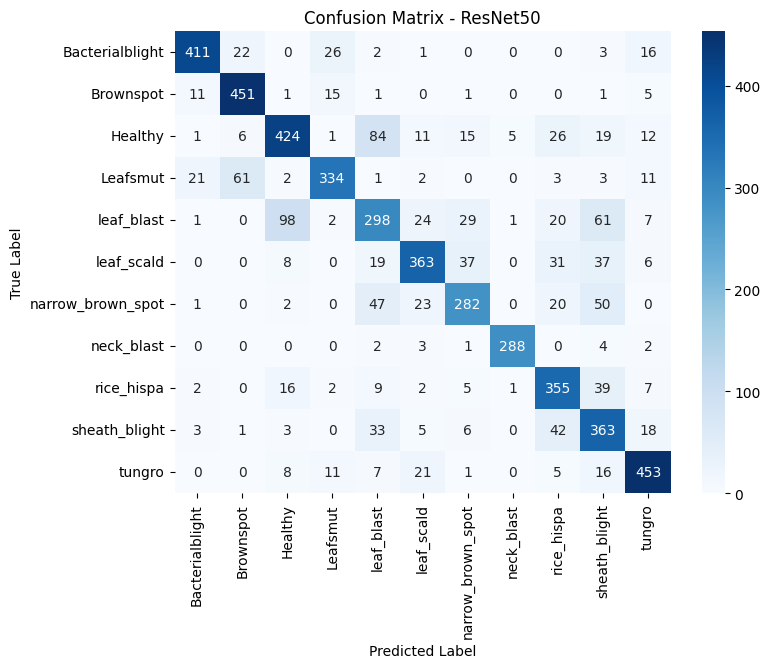

INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpmuvzryjx\assets


INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpmuvzryjx\assets


Saved artifact at 'C:\Users\MSC04\AppData\Local\Temp\tmpmuvzryjx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2433604647072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433605782512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433605789024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433605790960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433605788848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433605789376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433668311072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433668303504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433668310544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433668313184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2433

C:\Users\MSC04\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quantized ResNet50 Model - Accuracy: 0.2841
Quantized ResNet50 - Precision: 0.3758, Recall: 0.2841, F1 Score: 0.2356
Quantization failed for ResNet50: plot_confusion_matrix() got an unexpected keyword argument 'mode_name'
Current Learning Rate :  0.0001

--------------------------------------------------
Training ResNet50 Model
--------------------------------------------------
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.2010 - loss: 2.5418 - val_accuracy: 0.1184 - val_loss: 2.5735
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.3901 - loss: 2.0535 - val_accuracy: 0.1595 - val_loss: 2.4262
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.4418 - loss: 1.8818 - val_accuracy: 0.3200 - val_loss: 2.2339
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.4668 - loss: 1.7735 - val_accuracy: 0.4862 - val_loss: 2.0020
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.4783 - loss: 1.7127 - val_accuracy: 0.544

ResNet50 Model - Accuracy: 0.7585
ResNet50 Model size (full-precision): 93.63 MB
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step
ResNet50 Model - Precision: 0.7619, Recall: 0.7585, F1 Score: 0.7574
Confusion Matrix [[390  37   1  31   3   1   2   0   0   4  12]
 [ 15 456   1   8   0   0   0   0   0   0   6]
 [  1   8 445   3  67   8  13   6  18  18  17]
 [ 16  86   2 314   5   0   0   0   3   0  12]
 [  3   1 104   7 289  25  24   4  15  58  11]
 [  0   0  17   0  17 358  22   0  38  40   9]
 [  2   2   6   0  44  17 286   0  19  44   5]
 [  1   0   0   1   3   2   0 288   1   2   2]
 [  4   0  18   3  10   2   6   1 358  30   6]
 [  8   1   6   1  37   3   2   0  63 328  25]
 [  0   0   6  25   8  23   1   0   7  12 440]]


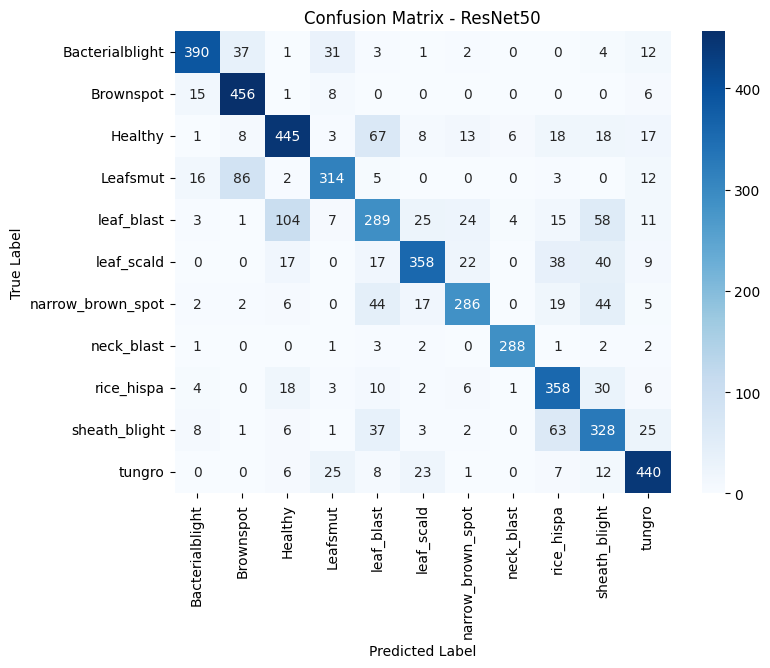

INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpkh4nayd9\assets


INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpkh4nayd9\assets


Saved artifact at 'C:\Users\MSC04\AppData\Local\Temp\tmpkh4nayd9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_180')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2440104045456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440104038944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440104040000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440104046160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440104039648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440104042112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440104045808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440107389200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440107389728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440107388144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

C:\Users\MSC04\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quantized ResNet50 Model - Accuracy: 0.2570
Quantized ResNet50 - Precision: 0.4202, Recall: 0.2570, F1 Score: 0.2103
Quantization failed for ResNet50: plot_confusion_matrix() got an unexpected keyword argument 'mode_name'
Current Learning Rate :  5e-05

--------------------------------------------------
Training ResNet50 Model
--------------------------------------------------
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.1779 - loss: 2.5939 - val_accuracy: 0.0923 - val_loss: 2.7126
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.3050 - loss: 2.2254 - val_accuracy: 0.1136 - val_loss: 2.5027
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.3640 - loss: 2.0785 - val_accuracy: 0.2257 - val_loss: 2.3234
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.3991 - loss: 1.9762 - val_accuracy: 0.4334 - val_loss: 2.1317
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.4264 - loss: 1.8982 - val_accuracy: 0.4821

ResNet50 Model - Accuracy: 0.7088
ResNet50 Model size (full-precision): 93.63 MB
41/41 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step
ResNet50 Model - Precision: 0.7120, Recall: 0.7088, F1 Score: 0.7077
Confusion Matrix [[365  40   1  47   3   1   2   0   0   8  14]
 [ 24 426   3  12   9   0   1   0   0   2   9]
 [  4   9 412   6  68  19  17   6  19  29  15]
 [ 18 106   2 272   6   3   1   0   4   2  24]
 [  3   6 103   8 256  32  22   8  20  70  13]
 [  0   0  12   0  22 351  27   0  37  43   9]
 [  3   1   4   1  39  27 275   1  19  51   4]
 [  1   0   0   1   9   4   2 277   1   3   2]
 [  6   0  19   4  16   4   6   1 323  43  16]
 [ 14   1   5   0  39   0   2   2  62 316  33]
 [  0   0   5  35   5  37   3   0   5  12 420]]


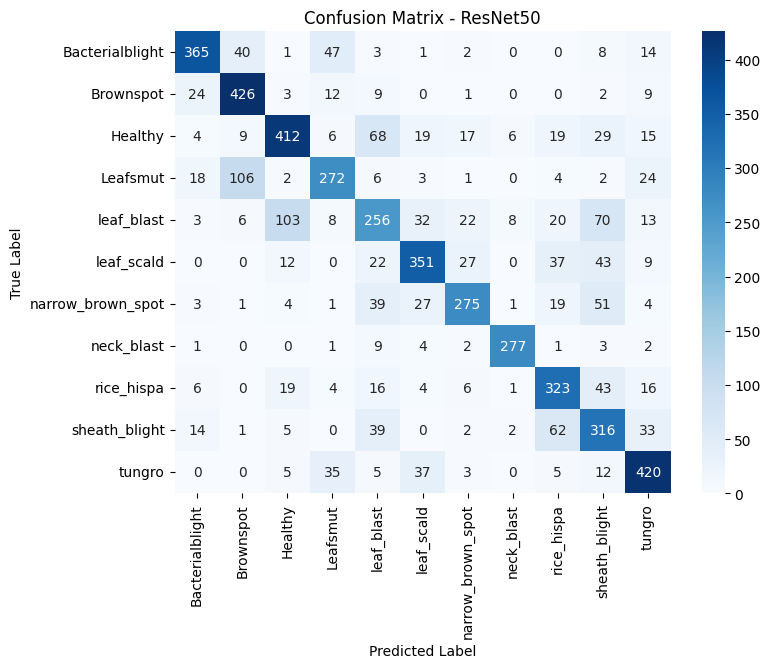

INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpgiazr6y4\assets


INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpgiazr6y4\assets


Saved artifact at 'C:\Users\MSC04\AppData\Local\Temp\tmpgiazr6y4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_360')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2440652399088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440652401552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440652402960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440652396448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440652400144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440652397680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440649041424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440649033328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440649040896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440649043536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

C:\Users\MSC04\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quantized ResNet50 Model - Accuracy: 0.2507
Quantized ResNet50 - Precision: 0.4410, Recall: 0.2507, F1 Score: 0.2124
Quantization failed for ResNet50: plot_confusion_matrix() got an unexpected keyword argument 'mode_name'

--------------------------------------------------
Training ResNet50 Model
--------------------------------------------------
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.3466 - loss: 2.1085 - val_accuracy: 0.1518 - val_loss: 3.2844
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.5188 - loss: 1.5367 - val_accuracy: 0.1927 - val_loss: 2.7256
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.5695 - loss: 1.3743 - val_accuracy: 0.2869 - val_loss: 2.1171
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.5907 - loss: 1.2791 - val_accuracy: 0.5063 - val_loss: 1.6371
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.6193 - loss: 1.2095 - val_accuracy: 0.6428 - val_loss: 1.3409
Epoch 6/100

ResNet50 Model - Accuracy: 0.7800
ResNet50 Model size (full-precision): 93.63 MB
41/41 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step
ResNet50 Model - Precision: 0.7830, Recall: 0.7800, F1 Score: 0.7790
Confusion Matrix [[418  33   1  20   3   0   0   0   0   2   4]
 [ 10 457   3  12   0   0   0   0   0   0   4]
 [  1   7 467   1  64   9   5   6  17  16  11]
 [ 21  74   1 321   2   5   0   0   2   3   9]
 [  2   0 109   5 304  30  19   0  18  46   8]
 [  0   0  15   0  19 384  15   0  29  32   7]
 [  1   0   6   0  53  30 278   0  18  38   1]
 [  0   0   1   1   1   2   0 290   2   1   2]
 [  5   1  18   1   7   7   4   1 367  22   5]
 [  8   1  10   1  42   7   2   1  47 339  16]
 [  0   0   4  23   5  29   1   0   6  15 439]]


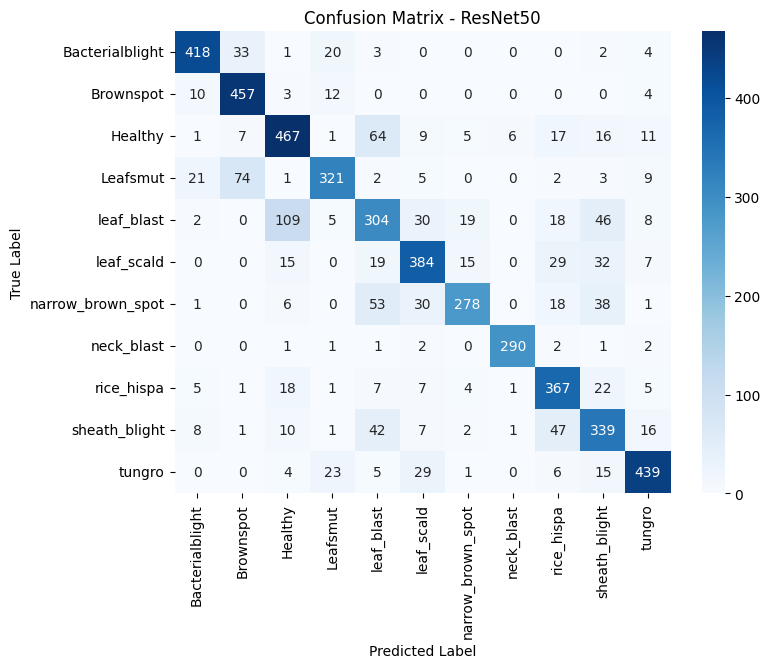

INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpiknpi82g\assets


INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpiknpi82g\assets


Saved artifact at 'C:\Users\MSC04\AppData\Local\Temp\tmpiknpi82g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_540')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2440668678448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440668677568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440668683552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440668682848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440668677392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440668679856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440668679680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440735224080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440735224608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2440735223024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

C:\Users\MSC04\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quantized ResNet50 Model - Accuracy: 0.3150
Quantized ResNet50 - Precision: 0.3440, Recall: 0.3150, F1 Score: 0.2699
Quantization failed for ResNet50: plot_confusion_matrix() got an unexpected keyword argument 'mode_name'


NameError: name 'history_dict' is not defined

In [14]:
# Function to train ResNet50 model separately
def train_resnet50(train_ds, val_ds, epochs, early_stop, learning_rate=0.001):
    print("\n" + "-"*50 + "\nTraining ResNet50 Model\n" + "-"*50)

    # Load and create the ResNet50 model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )
    for layer in base_model.layers:
        layer.trainable = False

    model = create_model(base_model)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop]
    )

    # Evaluate the full-precision model
    _, accuracy = model.evaluate(val_ds, verbose=0)
    print(f"ResNet50 Model - Accuracy: {accuracy:.4f}")

    # ---- ADDED: Save full-precision model and print its size
    model_path = "resnet50_model.h5"
    model.save(model_path)
    fp_size = os.path.getsize(model_path)
    print(f"ResNet50 Model size (full-precision): {fp_size / (1024 * 1024):.2f} MB")
    # ---- END ADDED

    # Collect true labels and predictions
    y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
    y_pred_prob = model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute precision, recall, f1
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"ResNet50 Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, model_name="ResNet50")

    # Quantization of the model
    quantized_model = None
    try:
        quantized_model = apply_quantization(model)
        print("Quantization successful for ResNet50.")

        # If we got raw TFLite bytes, write and interpret
        if isinstance(quantized_model, (bytes, bytearray)):
            tflite_path = "resnet50_quantized.tflite"
            with open(tflite_path, "wb") as f:
                f.write(quantized_model)

            interpreter = tf.lite.Interpreter(model_path=tflite_path)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            qt_size = os.path.getsize(tflite_path)
            print(f"Quantized ResNet50 Model size (TFLite): {qt_size / (1024 * 1024):.2f} MB")

            # Run inference sample-by-sample (batch dimension fixed at 1)
            yq_true, yq_pred = [], []
            for batch_x, batch_y in val_ds:
                x_np = batch_x.numpy()
                y_np = batch_y.numpy()
                for i in range(x_np.shape[0]):
                    sample = np.expand_dims(x_np[i], axis=0)
                    interpreter.set_tensor(input_details[0]['index'], sample)
                    interpreter.invoke()
                    out = interpreter.get_tensor(output_details[0]['index'])
                    pred = np.argmax(out, axis=1)[0]
                    yq_true.append(y_np[i])
                    yq_pred.append(pred)

            yq_true = np.array(yq_true)
            yq_pred = np.array(yq_pred)

            # Compute metrics for quantized model
            q_accuracy = np.mean(yq_true == yq_pred)
            q_precision = precision_score(yq_true, yq_pred, average='weighted')
            q_recall = recall_score(yq_true, yq_pred, average='weighted')
            q_f1 = f1_score(yq_true, yq_pred, average='weighted')

            print(f"Quantized ResNet50 Model - Accuracy: {q_accuracy:.4f}")
            print(f"Quantized ResNet50 - Precision: {q_precision:.4f}, Recall: {q_recall:.4f}, F1 Score: {q_f1:.4f}")
            plot_confusion_matrix(yq_true, yq_pred, mode_name="ResNet50 Quantized")

        else:
            # Keras model returned
            _, q_accuracy = quantized_model.evaluate(val_ds, verbose=0)
            print(f"Quantized ResNet50 Model - Accuracy: {q_accuracy:.4f}")

            yq_pred_prob = quantized_model.predict(val_ds)
            yq_pred = np.argmax(yq_pred_prob, axis=1)
            q_precision = precision_score(y_true, yq_pred, average='weighted')
            q_recall = recall_score(y_true, yq_pred, average='weighted')
            q_f1 = f1_score(y_true, yq_pred, average='weighted')
            print(f"Quantized ResNet50 - Precision: {q_precision:.4f}, Recall: {q_recall:.4f}, F1 Score: {q_f1:.4f}")
            plot_confusion_matrix(y_true, yq_pred, model_name="ResNet50 Quantized")

    except Exception as e:
        print(f"Quantization failed for ResNet50: {e}")

    return model, history, quantized_model
# Main loop for other models (excluding ResNet50)
# for name, base_model in models.items():
#     if name == "ResNet50":
#         continue
#     print(f"\n{'-'*50}\nOptimizing model: {name}\n{'-'*50}")

#     # Load and create the model
#     print("Creating and training original model...")
#     model = create_model(base_model)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train the model
#     early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#     history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])
#     history_dict[name] = {'original': history.history}

    # Continue with the rest of the optimization and evaluation as before...

# Separate training for ResNet50
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
learning_rates = [0.001,0.0001,0.00005]
#=0.001
EPOCHS = 100

for rates in learning_rates:
    print("Current Learning Rate : ",rates)
    resnet50_model, resnet50_history, resnet50_quantized = train_resnet50(train_ds, val_ds, EPOCHS, early_stop,rates)
    # history_dict['ResNet50'] = {'original': resnet50_history.history}
    
resnet50_model, resnet50_history, resnet50_quantized = train_resnet50(train_ds, val_ds, EPOCHS, early_stop)
history_dict['ResNet50'] = {'original': resnet50_history.history}

if resnet50_quantized:
    print("Quantized ResNet50 model available.")
else:
    print("No quantized ResNet50 model.")

# Further optimization steps for ResNet50 can be added here if needed.


In [ ]:
# # print(history_dict)

# # Evaluate the model (before quantization)
# acc, accuracy = evaluate_tflite_model(resnet50_quantized,val_ds)
# _,normal_acc = resnet50_model.evaluate(val_ds)
# print(f"ResNet50 Model - Validation Accuracy (Before quantization): {normal_acc:.4f}")
# print(f"ResNet50 Model - Validation Accuracy (After quantization): {accuracy:.4f} then normal acc : {acc}")

In [ ]:
# def get_model_size(model,suffix=".h5"):
#     # Save the model temporarily to calculate its size
#     size=None
#     if suffix==".tflite":
#         temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".tflite")
#         with open(temp_file.name, 'wb') as f:
#             f.write(model)
#         size= os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
#     elif suffix==".h5":
#         temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
#         model.save(temp_file.name)
#         size = os.path.getsize(temp_file.name) / (1024 * 1024)
#     return size
# print("Size Before Quantization : ", get_model_size(resnet50_model))
# print("Size After Quantization : ", get_model_size(resnet50_quantized,".tflite"))

In [ ]:
# # Collect true labels
# y_true = np.concatenate([y for x, y in val_ds])

# # Get predictions
# y_pred_prob = resnet50_model.predict(val_ds)
# y_pred = np.argmax(y_pred_prob, axis=1)


# # Code to get confusion matrices
# # Plot confusion matrix
# plot_confusion_matrix(y_true, y_pred, "REST NET ")

## EFFICIENT BV2


In [ ]:
# List of pre-trained models
models = {
    # "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
}

# Dictionary to store performance metrics
performance_metrics = {model_name: {
    "size": {},
    "inference_time": {},
    "accuracy": {}
} for model_name in models}

# Dictionary to store history for plotting
history_dict = {}

In [ ]:
# Set parameters
BATCH_SIZE = 128
IMG_SIZE = (260, 260)  # Standard for pre-trained models
EPOCHS = 8

In [ ]:
# # Load dataset
# train_ds = image_dataset_from_directory(
#     dataset_path,  # Replace with your dataset directory
#     validation_split=0.3,
#     subset="training",
#     seed=123,
#     image_size=IMG_SIZE,
#     # label_mode="categorical",
#     batch_size=BATCH_SIZE
# )

# val_ds = image_dataset_from_directory(
#     dataset_path,  # Replace with your dataset directory
#     validation_split=0.3,
#     subset="validation",
#     seed=123,
#     # label_mode="categorical",
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE
# )


# # Get class names
# class_labels = train_ds.class_names




# # Load dataset
# train_ds = image_dataset_from_directory(
#     dataset_path,  # Replace with your dataset directory
#     validation_split=0.3,
#     subset="training",
#     seed=123,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE
# )

# val_ds = image_dataset_from_directory(
#     dataset_path,  # Replace with your dataset directory
#     validation_split=0.3,
#     subset="validation",
#     seed=123,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     shuffle=False

# )


AUTOTUNE = tf.data.AUTOTUNE

# 1. Get image paths and labels
def get_image_paths_and_labels(dataset_path):
    class_names = sorted(os.listdir(dataset_path))
    filepaths = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(idx)
    return np.array(filepaths), np.array(labels), class_names

filepaths, labels, class_names = get_image_paths_and_labels(dataset_path)

# 2. Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    filepaths, labels, 
    test_size=0.3, 
    stratify=labels, 
    random_state=42
)

# 3. Image loading and preprocessing
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize
    return img, label

# 4. Build Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(process_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(process_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

NUM_CLASSES = 11

# === BASE MODEL ===
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))  # EfficientNetB2 default size
base_model.trainable = False  # Freeze base

# === TOP CLASSIFIER ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# === COMPILE MODEL ===
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# === CALLBACKS ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_effnetB2_model.h5', monitor='val_accuracy', save_best_only=True)

# === TRAIN MODEL ===
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop, checkpoint])
